# VAE training tutorial

This is a tutorial training a [VAE](https://arxiv.org/abs/1312.6114) on MNIST and latent analysis

Structure:

  * create encoder and decoder, choose latent and model distributions.
  * VAE training
  * check likelihood for overfitting.
  * latent analysis
  
  
  Your tasks:
  
   * define the decoder distribution
   * define the encoder distribution
   * define the terms of the loss
   * define the samples and reconstruction tensors
   * run the KL analysis 
   * run the latent traversal task
   * run the colab with a different number of latent dimensions (and see how that affects the kl analysis)
   
 

In [0]:
!pip install -q dm-sonnet
!pip install -q seaborn -U

## Imports

We will use Sonnet to define the encoder and decoder networks.

In [0]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import math

import tensorflow as tf
import sonnet as snt

import numpy as np

# Plotting library.
from matplotlib import pyplot as plt
import seaborn as sns

In [0]:
tf.logging.set_verbosity(tf.logging.ERROR)

In [0]:
sns.set(rc={"lines.linewidth": 2.8}, font_scale=2)
sns.set_style("whitegrid")

In [5]:
# Don't forget to select GPU runtime environment in Runtime -> Change runtime type
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Hyperparameters

In [0]:
BATCH_SIZE = 64  # @param
NUM_LATENTS = 20  # @param
TRAINING_STEPS = 10000 # @param

## Get the data

We will use the MNIST dataset. Luckly, TensorFlow comes with a simple way to load it. 

In [7]:
mnist = tf.contrib.learn.datasets.load_dataset("mnist")

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting MNIST-data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting MNIST-data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting MNIST-data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting MNIST-data/t10k-labels-idx1-ubyte.gz


In [8]:
print(mnist.train.images.shape)
print(type(mnist.train.images))

(55000, 784)
<type 'numpy.ndarray'>


### Transform the data from numpy arrays to graph tensors.

This allows us to use TensorFlow datasets, which ensure that a new batch from the data is being fed at each session.run. This means that we do not need to use feed_dicts to feed data to each session.

In [0]:
def make_tf_data_batch(np_data, shuffle=True):  
  # Reshape the data to image size.
  images = np_data.reshape((-1, 28, 28, 1))
  
  # Create the TF dataset.   
  dataset = tf.data.Dataset.from_tensor_slices(images)
  
  # Shuffle and repeat the dataset for training.
  # This is required because we want to do multiple passes through the entire
  # dataset when training.
  if shuffle:
    dataset = dataset.shuffle(100000).repeat()
    
  # Batch the data and return the data batch.
  one_shot_iterator = dataset.batch(BATCH_SIZE).make_one_shot_iterator()
  data_batch = one_shot_iterator.get_next()
  return data_batch

In [32]:
tf.reset_default_graph()
real_data = make_tf_data_batch(mnist.train.images)
print(real_data.shape)

(?, 28, 28, 1)


## Define the encoder and decoder (generator) networks

### Encoder network

We use a conv net encoder, and add a linear layer at the end - the latents will be 1D.

## Exercise: Fill in the distribution for the encoder

Remember: the encoder represents q(z|x)

In [0]:
class MnistEncoder(snt.AbstractModule):
  """The learned encoder distribution q(z|x).
  
    The output distribution will be a Normal distribution for each latent,
    with the mean and variance of the distribution being learned by gradient 
    descent.
    
    The variables of this module get a loss from both the likelihood and 
    the KL term. We do not have to worry about the reparamtrization trick, since
    TensorFlow implements that for us, for the Normal distribution.
  """

  def __init__(self, name='MnistEncoder'):
    super(MnistEncoder, self).__init__(name=name)

  def _build(self, input_image):
    """Constructs the encoder graph.

    Args:
      input_image: `tf.Tensor` input to be used by the encoder.

    Returns:
      `tf.Tensor` output with the decision of the encoder.
    """
    
    conv2d = snt.nets.ConvNet2D(
        output_channels=[8, 16, 32, 64, 128],
        kernel_shapes=[[5, 5]],
        strides=[2, 1, 2, 1, 2],
        paddings=[snt.SAME],
        activate_final=True,
        activation=tf.nn.relu,
        use_batch_norm=False)

    convolved = conv2d(input_image)
    
    # Flatten the data to 2D for getting the mean and variance from the encoder.
    flat_data = snt.BatchFlatten()(convolved)
    
    # TODO: build the encoder distribution q(z|x) for the given input.
    mu =  snt.Linear(NUM_LATENTS)(flat_data)
    sigma = snt.Linear(NUM_LATENTS)(flat_data)
    dist = tf.contrib.distributions.NormalWithSoftplusScale(mu, sigma)
    return dist

## Exercise: Fill in the distribution for the decoder

Remember: the decoder represents p(x|z)

### Decoder network

We use a simple Transpose convolutional network. Because the input to the model is 2 dimensional, we first use a linear layer to transform the input latents to a size suitable for the conv network.

In [0]:
class MnistDecoder(snt.AbstractModule):
  """The learned decoder distribution p(x|z).
  
    The variables of this module get a loss from the likelihood term and are
    trained using gradient descent.
  """

  def __init__(self, name='MnistDecoder'):
    super(MnistDecoder, self).__init__(name=name)

  def _build(self, inputs):
    """Constructs the generator graph.

    Args:
      inputs: `tf.Tensor` with the input of the generator.

    Returns:
      `tf.Tensor`, the generated samples.
    """
    linear = snt.Linear(7 * 7 * 64)
    inputs = linear(inputs)
    
    # Reshape the data to have rank 4.
    inputs = snt.BatchReshape((7, 7, 64))(inputs)
    inputs = tf.nn.relu(inputs)

    net = snt.nets.ConvNet2DTranspose(
        output_channels=[32, 1],
        output_shapes=[[14, 14], [28, 28]],
        strides=[2],
        paddings=[snt.SAME],
        kernel_shapes=[[5, 5]],
        use_batch_norm=False)


    # TODO: build the decoder distribution p(x|z) for the given input latents.
    #probs = tf.sigmoid(net)
    
    return tf.distributions.Bernoulli(net(inputs))

## VAE logic

Variational bound:
\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q(z|x)} \log p_\theta(x|z)  - \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

The aim of the model is to maximize the variational lower bound, so the negative of the bound is minimized.

<h2 align="center"></h2> <img src="http://elarosca.net/vae.png?format=100w" width=500 >



In [35]:
encoder = MnistEncoder()
decoder = MnistDecoder()

# Zero mean, unit variance prior.
prior_mean = tf.zeros(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
prior_scale = tf.ones(shape=(BATCH_SIZE, NUM_LATENTS), dtype=tf.float32)
prior = tf.distributions.Normal(loc=prior_mean, scale=prior_scale)

print('Latent samples {}'.format(prior.sample().shape))

Latent samples (64, 20)


## Define the graph for the loss

Since we want to maximize the bound on the log probability of the data, we minimize the negative of the bound.

The terms of the bound are: the log prob term, and the KL term.

### Log prob term

Reminder: this term ensures reconstructions will look good.

\begin{equation}
 \mathbb{E}_{p^*(x)} \mathbb{E}_{q^(z|x)} \log p_\theta(x|z)
\end{equation}


### KL term

Reminder: this term ensures model samples (obtained by sampling from the prior and doing a forward pass through the decoder) are close to data reconstructions (which are obtained by doing a pass through the encoder, getting posterior samples, and then using them to generate data reconstructions).

\begin{equation}
 - \mathbb{E}_{p^*(x)} KL(q(z|x)||p(z))
\end{equation}

## Exercise: Fill in the individual losses

The KL and the reconstruction loss.

In [0]:
def bound_terms(data_batch):

  # Define the posterior distribution
  
  posterior_distribution = encoder(data_batch)
  
  # Samples from q(z |x )   
  latent_sample = posterior_distribution.sample()

  #  Samples from p(x | z)
  all_log_probs = decoder(latent_sample).log_prob(data_batch)

  # Since we used broadcasting, log_prob of a Bernoulli will return a log_prob for 
  # each dimension.
  all_log_probs.shape.assert_is_compatible_with([BATCH_SIZE, 28, 28, 1])

  # Reduce sum over the data dimensions
  likelihood_term = tf.reduce_sum(all_log_probs, axis=[1, 2, 3])

  # Reduce mean over the batch dimensions
  likelihood_term = tf.reduce_mean(likelihood_term)

  # Define the KL divergence   
  all_kls = tf.distributions.kl_divergence(posterior_distribution, tf.distributions.Normal(0.,1.))
  all_kls.shape.assert_is_compatible_with([BATCH_SIZE, NUM_LATENTS])

  # Reduce sum over the latent dimensions.
  kl_term = tf.reduce_sum(all_kls, axis=[1])

  # Reduce over the batch dimension.
  kl_term = tf.reduce_mean(kl_term)
  
  return likelihood_term, kl_term

## Exercise: Total Loss 

Combine the likelihood term and the KL term to define the likelihood bound and the loss.

Remember: we will minimize the loss, but we want to maximize the bound.

In [0]:
# Maximize the data likelihodd and minimize the KL divergence between the prior and posterior
likelihood_term, kl_term = bound_terms(real_data)
train_bound = likelihood_term - kl_term
loss =  -train_bound

## Exercise: Define the sample and reconstruction tensors

Note: VAEs have no direct cost on samples. The quality of the samples improves, because the likelihood term ensures that the model will reconstruct well, while the KL term brings samples close to reconstructions.



In [0]:
samples = decoder(prior.sample()).mean()

In [0]:
reconstructions = decoder(encoder(real_data).sample()).mean()

## Define the optimizer

We will train the encoder and decoder jointly, to minimize the same loss.

In [0]:
optimizer = tf.train.AdamOptimizer(0.001, beta1=0.9, beta2=0.9)
update_op = optimizer.minimize(loss)

## Create the tensorflow session

In [0]:
sess = tf.Session()

# Initialize all variables
sess.run(tf.global_variables_initializer())

## Training

In [61]:
losses = []

for i in xrange(TRAINING_STEPS):
  sess.run(update_op)
  
  if i % 100 == 0:
    iteration_loss = sess.run(loss)
    print('Iteration {}. Loss {}'.format(i, iteration_loss))
    losses.append(iteration_loss)

Iteration 0. Loss 102.472946167
Iteration 100. Loss 98.1685333252
Iteration 200. Loss 100.0027771
Iteration 300. Loss 97.8466033936
Iteration 400. Loss 98.8439331055
Iteration 500. Loss 100.229896545
Iteration 600. Loss 99.4468994141
Iteration 700. Loss 104.169052124
Iteration 800. Loss 98.7229995728
Iteration 900. Loss 99.6890487671
Iteration 1000. Loss 100.461181641
Iteration 1100. Loss 98.8561859131
Iteration 1200. Loss 97.5626754761
Iteration 1300. Loss 100.906196594
Iteration 1400. Loss 96.7660064697
Iteration 1500. Loss 105.71421051
Iteration 1600. Loss 97.7735290527
Iteration 1700. Loss 103.319534302
Iteration 1800. Loss 98.0212554932
Iteration 1900. Loss 100.839508057
Iteration 2000. Loss 101.378799438
Iteration 2100. Loss 100.863891602
Iteration 2200. Loss 95.7691497803
Iteration 2300. Loss 100.896820068
Iteration 2400. Loss 90.1040039062
Iteration 2500. Loss 100.228927612
Iteration 2600. Loss 92.0172271729
Iteration 2700. Loss 97.8779296875
Iteration 2800. Loss 100.213653564


Iteration 7500. Loss 99.94090271
Iteration 7600. Loss 97.9059829712
Iteration 7700. Loss 100.552688599
Iteration 7800. Loss 101.376296997
Iteration 7900. Loss 95.4053115845
Iteration 8000. Loss 96.0592422485
Iteration 8100. Loss 99.0835342407
Iteration 8200. Loss 99.9079208374
Iteration 8300. Loss 95.0185546875
Iteration 8400. Loss 96.5794219971
Iteration 8500. Loss 93.8894195557
Iteration 8600. Loss 101.99130249
Iteration 8700. Loss 100.032836914
Iteration 8800. Loss 100.38747406
Iteration 8900. Loss 102.076553345
Iteration 9000. Loss 95.2856292725
Iteration 9100. Loss 97.5056533813
Iteration 9200. Loss 94.8116607666
Iteration 9300. Loss 97.7308883667
Iteration 9400. Loss 98.1273956299
Iteration 9500. Loss 98.5042572021
Iteration 9600. Loss 99.1318511963
Iteration 9700. Loss 99.6217193604
Iteration 9800. Loss 100.709671021
Iteration 9900. Loss 96.6425018311


## Visualize the loss in time

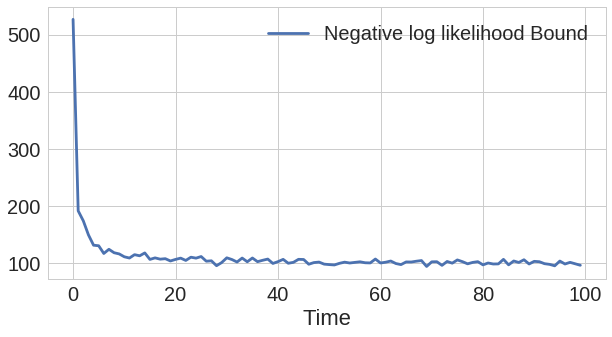

In [50]:
plt.figure(figsize=(10,5))
plt.plot(losses, label='Negative log likelihood Bound')
plt.xlabel('Time')
plt.legend()

## Visualize samples, reconstructions

In [0]:
def gallery(array, ncols=10, rescale=True):
    if rescale:
      array = (array + 1.) / 2
    nindex, height, width, intensity = array.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    # want result.shape = (height*nrows, width*ncols, intensity)
    result = (array.reshape(nrows, ncols, height, width, intensity)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols, intensity))
    return result


In [85]:
real_data_examples = sess.run(real_data)
final_samples = sess.run(samples)
data_reconstructions = sess.run(reconstructions)
print(data_reconstructions.shape)

(64, 28, 28, 1)


### Real data

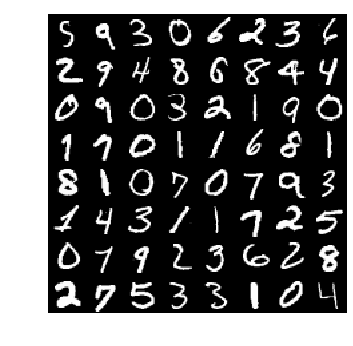

In [86]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(real_data_examples, ncols=8).squeeze(axis=2))

### Samples

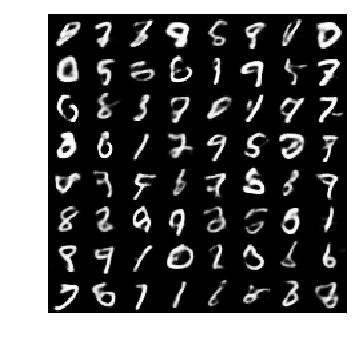

In [87]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(final_samples, ncols=8).squeeze(axis=2))

### Reconstructions

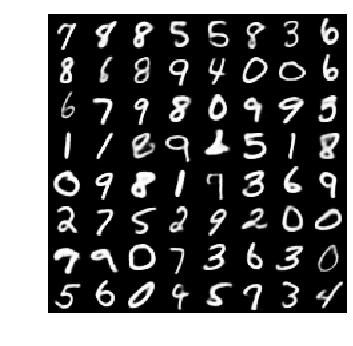

In [88]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(data_reconstructions, ncols=8).squeeze(axis=2))

## Final training log prob aver multiple batches

In [0]:
NUM_TEST_BATCHES = 10 # @param

In [90]:
train_log_prob = []

for _ in xrange(NUM_TEST_BATCHES):
  train_log_prob.append(sess.run(train_bound))
  
train_avg_log_prob = np.mean(train_log_prob)
  
print('Averaged training log prob bound {}'.format(train_avg_log_prob))

Averaged training log prob bound -96.9160614014


## Exercise: Checking for overfitting - test likelihoods


We want to ensure that the model has not overfitted - to do that, we see if it gives a higher likelihood to training data compared to test data. If this is the case, we can conclude the model is overfitting.

### Get test data

In [0]:
test_data_batch = make_tf_data_batch(mnist.test.images)

In [0]:
likelihood_term_t, kl_term_t = bound_terms(test_data_batch)
test_bound = likelihood_term_t - kl_term_t


In [94]:
test_log_prob = []

for _ in xrange(NUM_TEST_BATCHES):
  test_log_prob.append(sess.run(test_bound))
  
test_avg_log_prob = np.mean(test_log_prob)
  
print('Averaged test log prob bound {}'.format(test_avg_log_prob))


Averaged test log prob bound -98.7169418335


## Analyse the structure of the latent variables

VAEs are generative and inference models. So far we have looked at samples, and reconstructions, but we have not looked at the learned representations. 

We will now analyze the learned VAE representations by looking at the KLs per latent, but also by doing latent space traversals.

Remember that the KL term is important, since the KL term ensures that the quality of the samples is going to be close to that of the reconstrunctions.


In [0]:
num_batches = int(mnist.train.images.shape[0] / BATCH_SIZE)
data_batch = make_tf_data_batch(mnist.train.images, shuffle=False)

In [0]:
posterior_distribution = encoder(data_batch)

all_kls = tf.distributions.kl_divergence(posterior_distribution, prior)
all_kls.shape.assert_is_compatible_with([BATCH_SIZE, NUM_LATENTS])

# Reduce over the batch dimension.
kls = tf.reduce_mean(all_kls, axis=[0])
kls.shape.assert_is_compatible_with([NUM_LATENTS])

In [0]:
aggregate_kl = np.zeros([NUM_LATENTS])
for _ in xrange(num_batches):
  aggregate_kl += sess.run(kls)
  
aggregate_kl /= num_batches

### Plot the kl divergences per latent

Because we used a factorizable prior (a Gaussian with unit covariance), the KL divergence
also factorizes, and we can see a KL divergence per unit). Here we analyze the KL divergence of each unit, to see how the model uses each latent unit.

We will see that if we increase the number of latent variables, the VAE "turns off" units, by setting their distribution to that of the prior.

TypeError: ignored

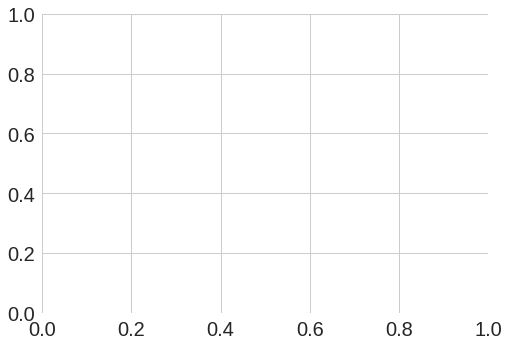

In [103]:
def get_grid_size(num_latents):
  num_latents_sqrt = np.sqrt(num_latents)
  width = int(num_latents_sqrt)
  while num_latents % width !=0:
    width -= 1
  return width, int(num_latents / width)

aggregate_kl = np.reshape(aggregate_kl, get_grid_size(NUM_LATENTS))
cmap = sns.cubehelix_palette(4, start=2, rot=0, dark=0, light=.96)
np.random.shuffle(aggregate_kl)
sns.heatmap(aggregate_kl, vmin=0, vmax=2, linewidths=.05, cmap=cmap)
plt.axis('off')


## Latent space interpolation

By doing an interpolation in latent space, we can analyze the behaviour of the model.

In [0]:
a = np.linspace(0.0, 1.0, 100)
a = np.expand_dims(a, axis=1)

first_latents = tf.random_normal((1, NUM_LATENTS))
second_latents = tf.random_normal((1, NUM_LATENTS))

interpolations =  np.sqrt(a) * first_latents + np.sqrt(1 - a) * second_latents
# interpolations =  a * first_latents + (1 - a) * second_latents

samples_from_interpolations = decoder(interpolations).mean()


In [0]:
samples_from_interpolations_np = sess.run(samples_from_interpolations)

In [106]:
print(samples_from_interpolations_np.shape)

(100, 28, 28, 1)


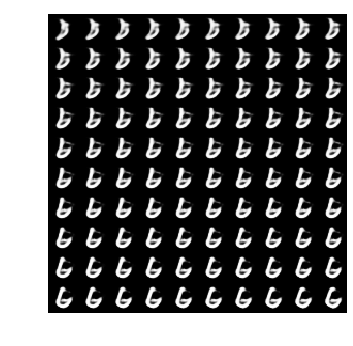

In [107]:
plt.gray()
plt.axis('off')
plt.imshow(gallery(samples_from_interpolations_np).squeeze(axis=2))
plt.show()

### Exercise: change the number of latents (to 100) and see what happens with the KL plot.



## Close session

In [0]:
# sess.close()

## Reflections

* What can VAEs be used for?
* How do VAEs learn to sample?

### VAE samples on other datasets

Note: these are samples with the vanilla algorithm, but they can be improved using better complex distributions.

#### CIFAR-10
<h2 align="center"></h2> <img src="http://elarosca.net/cifar_vae_samples_last.jpeg?format=100w" width=500 >

#### CelebA
# <h2 align="center"></h2> <img src="http://elarosca.net/celeba_vae_samples_last.jpeg?format=100w" width=500 >

